In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np



In [2]:
# load data
# https://www.kaggle.com/jpacse/datasets-for-churn-telecom

In [3]:
df = pd.read_csv('./data/WA_Fn-UseC_-Telco-Customer-Churn.csv')
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


### 
- there are 57 feautures, and 1 target ('churn')
- there are 51047 records (including missing values)
- note that our target is a categorical variable, so we are working on a classsification problem, to be more specific, binary classification problem

In [4]:
# missing data

In [5]:
# import missingno as msno

# missing_values = df.isnull().sum() / len(df)
# missing_values = missing_values[missing_values > 0]
# missing_values.sort_values(inplace=True)
# print(missing_values)

# msno.matrix(df[missing_values.index])

In [6]:
df_original = df.copy()

In [7]:
# clean the data, SeniorCitizen is actually boolen
df['SeniorCitizen'] = df['SeniorCitizen'].map({1:'Yes', 0:'No'})
# df

In [8]:
# TotalCharges actually is float-type but with nan value
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')


In [9]:
# drop nan (since not loss too much data)
df.dropna(inplace=True)

# also drop ID features, unless we can extract certain useful infomation, it looks pretty random
df = df.drop('customerID', axis=1)

In [10]:
# coutinous and categorical variables

In [11]:
print("number of object variables: {}".format(len(df.select_dtypes(include='object').columns)))
print("number of int variable: {}".format(len(df.select_dtypes(include='int64').columns)))
print("number of float variable: {}".format(len(df.select_dtypes(include='float').columns)))

# df_object = df.select_dtypes(include='object')
# df_continous = df.select_dtypes(exclude='object')
val_num =[df[col].nunique() for col in df.columns]
df_val_count = pd.concat([pd.DataFrame(df.columns), 
                          pd.DataFrame(val_num), 
                          pd.DataFrame(df.dtypes.values)], axis=1)
df_val_count.columns = ['col_name', 'val_count', 'dtypes']
df_val_count = df_val_count.sort_values(by=['val_count'])
# df_val_count[df_val_count.val_count <100]
df_val_count

number of object variables: 17
number of int variable: 1
number of float variable: 2


,col_name,val_count,dtypes
0,gender,2,object
15,PaperlessBilling,2,object
5,PhoneService,2,object
19,Churn,2,object
2,Partner,2,object
1,SeniorCitizen,2,object
3,Dependents,2,object
6,MultipleLines,3,object
7,InternetService,3,object
8,OnlineSecurity,3,object


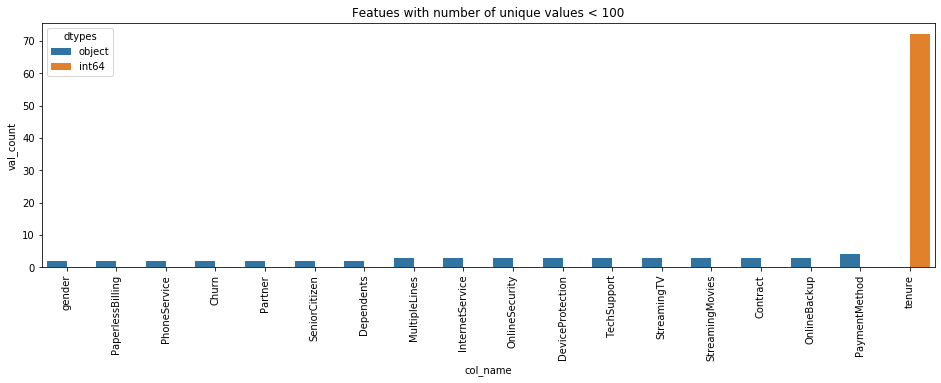

In [12]:
plt.figure(figsize=(16,4.5))
sns.barplot(
    data= df_val_count[df_val_count.val_count<100],
    x= 'col_name',
    y= 'val_count',
    hue = 'dtypes')
plt.xticks(rotation=90)
plt.title('Featues with number of unique values < 100')
plt.show()

###
- there are 35 non-object-type variables, 23 object-type variables, 
- 22 out of 23 have less-than-20 unique values,"ServiceArea" 743 unique variables
- except "serviceArea", the other 22 object-type variables can be easily handled using one-hot-encoding.
- for "serviceArea" variable, we need to either use models that can handel categorical type or just drop it.
- some int variables have categorical-variable-like features, i.e. "RetentionOffersAccepted", "RetentionCalls", which have less than 10 unique values, and might need special attention, i.e. when performing outlier reduction.

In [13]:
# outliers inspection (on continous variable)

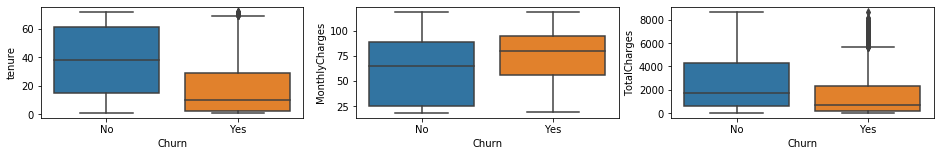

In [14]:
plt.figure(figsize=(16,4.5))
df_tmp = df
col_num_tmp = len(df_tmp.select_dtypes(exclude='object').columns)
for index in range(1, col_num_tmp+1):
    plt.subplot(col_num_tmp//3+1, 3, index)
    col = df_tmp.select_dtypes(exclude='object').columns[index - 1]
    sns.boxplot( y = col, orient='vertical', x= 'Churn', data=df)
#     sns.boxplot( y = col, orient='vertical', data=df)

###
- many columns exist outliers
- we can use windorization to handel outliers
- as mentioned before, some int variables have categorical-variable-like features, i.e. "RetentionOffersAccepted", "RetentionCalls", which have less than 10 unique values, and might need special attention, i.e. when performing outlier reduction.

In [15]:
# univariant analysis - distributions

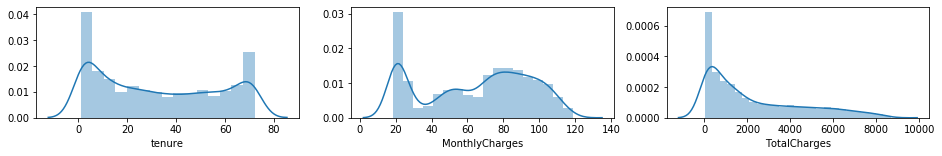

In [16]:
# for continous variables, histogram (or countplot for extreme cases)
plt.figure(figsize=(16,4.5))
df_tmp = df
col_num_tmp = len(df_tmp.select_dtypes(exclude='object').columns)
for index in range(1, col_num_tmp+1):
    plt.subplot(col_num_tmp//3+1, 3, index)
    col = df_tmp.select_dtypes(exclude='object').columns[index - 1]
    try:
        sns.distplot(a = df_tmp[col])
    except:
#         sns.distplot(a = df[col], kde=False)
        sns.countplot(df[col])
        plt.xticks(rotation=90)
    


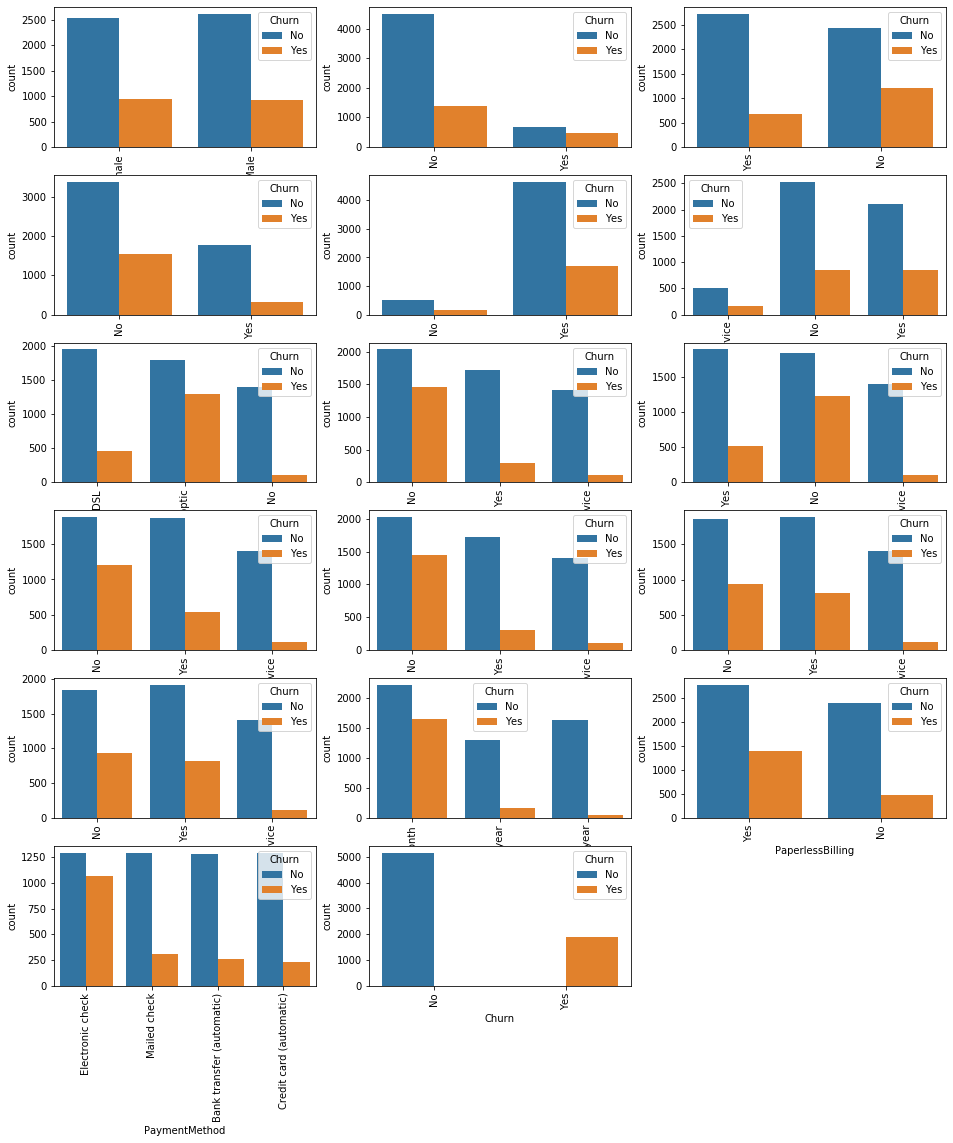

In [17]:
# distribution for object variables

plt.figure(figsize=(16,18))
df_tmp = df
col_num_tmp = len(df_tmp.select_dtypes(include='object').columns)
for index in range(1, col_num_tmp+1):
    plt.subplot(col_num_tmp//3+1, 3, index)
    col = df_tmp.select_dtypes(include='object').columns[index - 1]
    
    ax = sns.countplot(data = df, x=col, hue="Churn")
    plt.xticks(rotation=90)
#     if col == 'ServiceArea':
#         ax.set_xticklabels(labels=[])
#         start, end = ax.get_xlim()
#         ax.xaxis.set_ticks(np.arange(start, end, (end-start)//5))

In [18]:
print("the ratio of churn/not churn is: {}".format(df.Churn[df.Churn=='Yes'].count()/df.Churn[df.Churn!='Yes'].count()))

the ratio of churn/not churn is: 0.36199883788495063


In [19]:
# our target variable is somewhat balanced, the ratio of churn/not churn is: 0.40 in the training set
# some continous variables are very skewed, which is consistent with our observation that many outliers on one side.
# we might want to trasnform the data to make it more normal, based on the model to use, i.e. linear regression

In [20]:
# collinearity
# last but not last, let's check coolinearity between continous variables

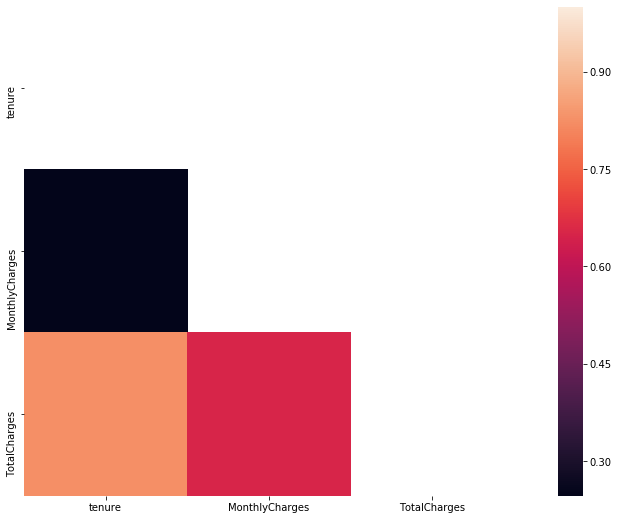

In [21]:
# visualize the correlationship using heatmap
# note: we only care about the absolute value,
# note: either lower triangle or upper triangle would gives the info
corr_matrix = df.select_dtypes(exclude='object').corr()
corr_matrix = np.abs(corr_matrix)
mask = np.triu(np.ones_like(corr_matrix, dtype=np.bool))

plt.figure(figsize=(16,9))
sns.heatmap(corr_matrix, square=True, mask=mask)

In [22]:
colli_threshold = 0.7
high_colli_list = []
for row in np.arange(len(corr_matrix)):
    for col in np.arange(row):
        if corr_matrix.iloc[row, col] >= colli_threshold:
            high_colli_list.append([corr_matrix.index[row], corr_matrix.columns[col]])
#             print("{} - {}".format(corr_matrix.index[row], corr_matrix.columns[col]))
print("when threshold is: {}, there are {} high collinearity-pairs.".format(colli_threshold, len(high_colli_list)))
print(" ")
print("high collinearity pairs:")
for item in high_colli_list:
    print("{} - {}".format(item[0], item[1]))

when threshold is: 0.7, there are 1 high collinearity-pairs.
 
high collinearity pairs:
TotalCharges - tenure


###
- collinear features can cause some problems, i.e. it might cause instablity for many parameter-based estimators
- we might want to get rid of one of the features in the aforementioned feature pairs.

# Data Cleaning and Feature Engineering in pipelines
- The data preprocessing might include missing data handeling, outlier reduction, categorical data encoding, data transformation (i.e. Logarithmic transform, standardization, normalization, PCA).
- As mentioned before, each model might have its specific requirement for data quality and/or features, i.e. KNN require data standardization to achieve better performance, while might not be mandatory for other estimators. logistic regression model is sensitive to outliers, but certain ensemble model like random forest is insensitive to outliers. Even for different Python packages, the requirement for data can be different, i.e. Sklearn package ask for one-hot-encoding data to handle categorical features, while package like h2o can deal with categorical data directly.
- The idea here is try to perform minimium data preprocessing to achieve best model performance, without compromising interpretability, i.e. we might lose intereability of original features after PCA. 
- Accordingly, we will perform specific data cleaning and feature engineering techniques for the particular machine learning models for classification, i.e logistic regression, KNN, decision tree, random forest, naive bayes, SVM, gradient boosting, XGBoost. 
- In addition, we will utilize Sklearn pipeline module to make the preproceesing more managable and neat.

## Data split before feature engineering
- In a real-world situation the data used for evaluation is unseen during training, which means such data is unseen for feature engineering process. So it is only fair to split the data into training set and test set before data cleaning and feature engineering. (Though we did fix the missing data problem)
- This is the reason we choose Sklearn pipeline module. Since we can easily perform the same preprocessing on both training set and test set.

In [23]:
from sklearn.model_selection import train_test_split

X = df.copy()
X = X.drop('Churn', axis=1)
y = df.Churn
X_train,  X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42 )

# reorder the index
X_train = X_train.reset_index().drop('index', axis=1)
X_test = X_test.reset_index().drop('index', axis=1)
y_train = y_train.reset_index().drop('index', axis=1)
y_test = y_test.reset_index().drop('index', axis=1)


## Data transformation (for numerical data)
- Several data transformation techniques, i.e. logarithmic transformation, boxcox transformation can reduce outlier numbers and make more normal-distribution-like.
- We will utilize the modules in Sklearn's preprocessing package, potential transformation include RobustScaler, PowerTransformer, QuantileTransformer, Normalizer. [Compare the effect of different scalers on data with outliers](https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html) We will choose QuantileTransformer with normal distribution output as the transformer, which has the best performance among others.
- Note that such transform only perform on numerical data, to more specific, only on float-type data. Since in this data set, the int-type features are actually ordinal categorical data, and it is more likely to perform better when treated as other categorical data in classification problem.

In [24]:
from sklearn.preprocessing import QuantileTransformer
quantile_transformer = QuantileTransformer(output_distribution='normal')
# quantile_transformer = QuantileTransformer(output_distribution='uniform')
X_train_quantrans = quantile_transformer.fit_transform(X_train.select_dtypes(include=['float', 'int64']))
# X_train_quantrans

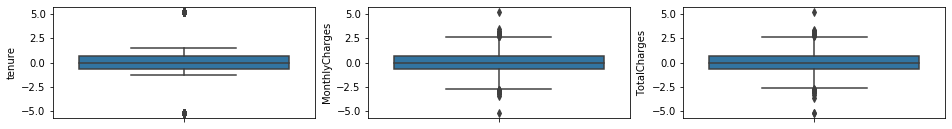

In [25]:
X_train_quantrans = pd.DataFrame(X_train_quantrans)
X_train_quantrans.columns = X_train.select_dtypes(include=['float', 'int64']).columns
plt.figure(figsize=(16,4.5))
for index in range(1, len(X_train_quantrans.columns)+1):
    plt.subplot(len(X_train_quantrans.columns)//3+1, 3, index)
    col = X_train_quantrans.columns[index - 1]
    sns.boxplot( y = col, orient='vertical',  data=X_train_quantrans)
#     sns.boxplot( y = col, orient='vertical', data=df)

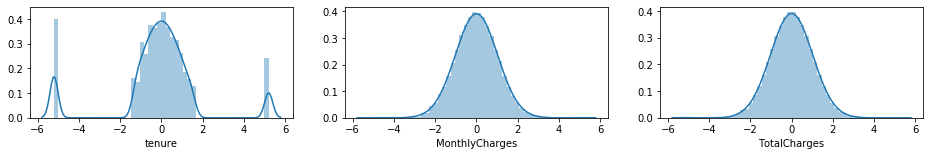

In [26]:
plt.figure(figsize=(16,4.5))
for index in range(1, len(X_train_quantrans.columns)+1):
    plt.subplot(len(X_train_quantrans.columns)//3+1, 3, index)
    col = X_train_quantrans.columns[index - 1]
    try:
        sns.distplot(a = X_train_quantrans[col])
    except:
#         sns.distplot(a = df[col], kde=False)
        sns.countplot(X_train_quantrans[col])
        plt.xticks(rotation=90)

###
- After the QuantileTransformation, the feature distributions have become more normal, also the number of outliers has decreased significantly than before.
- Note that, some transformed features have more than one peak, and it is hard to determine which should be considered as outliers. A potential method is to transform such features into binary variables. i.e. transfer "AgeHH2" to "AgeHH2_negativefive", "AgeHH2_zero".
- In this project, we just pick the features with accetable outlier profile. 
- Again, the aforementioned feature engineering process is necessary for those algorithms that are senstive to outliers.Note that not all the machine learning models are sensitive to outliers.

In [27]:
# use normality test to pick features
from scipy.stats import normaltest, shapiro

nor_threshold = 0.8
col_list = []
for col in X_train_quantrans.columns:
    k2, p = shapiro(X_train[col])
#     print(col)
#     print(k2, p)
    if k2 > nor_threshold:
        col_list.append(col)
# col_list

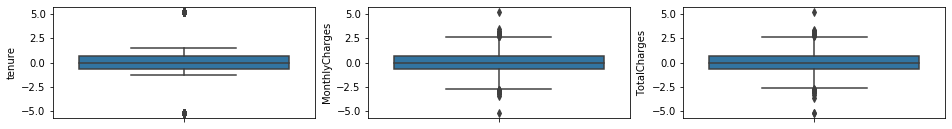

In [28]:
df_tmp = X_train_quantrans[col_list]

plt.figure(figsize=(16,4.5))
for index in range(1, len(df_tmp.columns)+1):
    plt.subplot(len(df_tmp.columns)//3+1, 3, index)
    col = df_tmp.columns[index - 1]
    sns.boxplot( y = col, orient='vertical',  data=df_tmp)
#     sns.boxplot( y = col, orient='vertical', data=df)

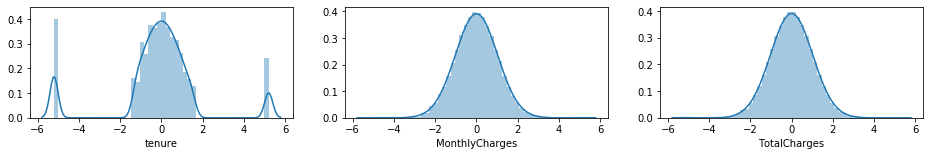

In [29]:
df_tmp = X_train_quantrans[col_list]

plt.figure(figsize=(16,4.5))
for index in range(1, len(df_tmp.columns)+1):
    plt.subplot(len(df_tmp.columns)//3+1, 3, index)
    col = df_tmp.columns[index - 1]
    try:
        sns.distplot(a = df_tmp[col])
    except:
#         sns.distplot(a = df[col], kde=False)
        sns.countplot(df_tmp[col])
        plt.xticks(rotation=90)

In [30]:
# the transformation can apply to the "unseen" test data as well
X_train_select = X_train[col_list]
X_test_select = X_test[col_list]

X_train_select_quantrans = quantile_transformer.fit_transform(X_train_select)
X_test_select_quantrans = quantile_transformer.transform(X_test_select)

X_train_select_quantrans = pd.DataFrame(X_train_select_quantrans)
X_test_select_quantrans = pd.DataFrame(X_test_select_quantrans)

X_train_select_quantrans.columns = col_list
X_test_select_quantrans.columns = col_list
# X_test_select_quantrans

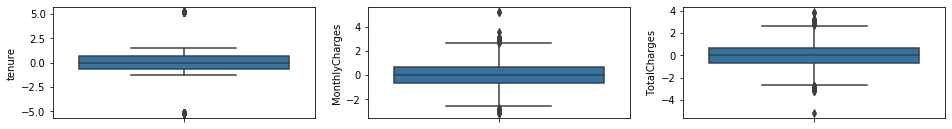

In [31]:
df_tmp = X_test_select_quantrans[col_list]

plt.figure(figsize=(16,4.5))
for index in range(1, len(df_tmp.columns)+1):
    plt.subplot(len(df_tmp.columns)//3+1, 3, index)
    col = df_tmp.columns[index - 1]
    sns.boxplot( y = col, orient='vertical',  data=df_tmp)
#     sns.boxplot( y = col, orient='vertical', data=df)

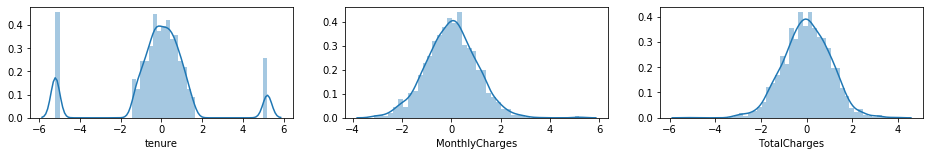

In [32]:
df_tmp = X_test_select_quantrans[col_list]

plt.figure(figsize=(16,4.5))
for index in range(1, len(df_tmp.columns)+1):
    plt.subplot(len(df_tmp.columns)//3+1, 3, index)
    col = df_tmp.columns[index - 1]
    try:
        sns.distplot(a = df_tmp[col])
    except:
#         sns.distplot(a = df[col], kde=False)
        sns.countplot(df_tmp[col])
        plt.xticks(rotation=90)

In [33]:
# from sklearn.preprocessing import OneHotEncoder

# # enc = OneHotEncoder(handle_unknown='error', sparse=False, drop='first')
# enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
# # X_train_dummy = enc.fit(X_train.drop('ServiceArea', axis=1).select_dtypes(include='object'), )
# X_train_dummy = enc.fit_transform(X_train.drop('ServiceArea', axis=1).select_dtypes(include='object'), )
# X_test_dummy = enc.transform(X_test.drop('ServiceArea', axis=1).select_dtypes(include='object'))

# col_encoding_list = enc.get_feature_names(X_train.drop('ServiceArea', axis=1).select_dtypes(include='object').columns)

# df_X_train_dummpy = pd.DataFrame(X_train_dummy)
# df_X_train_dummpy.columns = col_encoding_list
# df_X_test_dummpy = pd.DataFrame(X_test_dummy)
# df_X_test_dummpy.columns = col_encoding_list

In [34]:
from sklearn.preprocessing import OneHotEncoder

# enc = OneHotEncoder(handle_unknown='error', sparse=False, drop='first')
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
# X_train_dummy = enc.fit(X_train.drop('ServiceArea', axis=1).select_dtypes(include='object'), )
X_train_dummy = enc.fit_transform(X_train.select_dtypes(include='object'), )
X_test_dummy = enc.transform(X_test.select_dtypes(include='object'))

col_encoding_list = enc.get_feature_names(X_train.select_dtypes(include='object').columns)

df_X_train_dummpy = pd.DataFrame(X_train_dummy)
df_X_train_dummpy.columns = col_encoding_list
df_X_test_dummpy = pd.DataFrame(X_test_dummy)
df_X_test_dummpy.columns = col_encoding_list

In [35]:
# # our data to work on now
# X_train_1 = pd.concat([X_train_select_quantrans, df_X_train_dummpy, X_train.select_dtypes(include='int64')], axis=1)
# X_test_1 = pd.concat([X_test_select_quantrans, df_X_test_dummpy, X_test.select_dtypes(include='int64')], axis=1)

# # y_train_1 = pd.get_dummies(y_train, drop_first=True)
# # y_test_1 = pd.get_dummies(y_test, drop_first=True)

# y_train_1 = y_train.copy()
# y_gest_1 = y_test.copy()

In [36]:
# our data to work on now
X_train_1 = pd.concat([X_train_select_quantrans, df_X_train_dummpy], axis=1)
X_test_1 = pd.concat([X_test_select_quantrans, df_X_test_dummpy], axis=1)

# y_train_1 = pd.get_dummies(y_train, drop_first=True)
# y_test_1 = pd.get_dummies(y_test, drop_first=True)

y_train_1 = pd.get_dummies(y_train, drop_first=True)
y_test_1 = pd.get_dummies(y_test, drop_first=True)

In [37]:
# our data to work on now, without quantrans
X_train_2 = pd.concat([X_train_select, df_X_train_dummpy], axis=1)
X_test_2 = pd.concat([X_test_select, df_X_test_dummpy], axis=1)

# y_train_1 = pd.get_dummies(y_train, drop_first=True)
# y_test_1 = pd.get_dummies(y_test, drop_first=True)

# y_train_1 = pd.get_dummies(y_train, drop_first=True)
# y_test_1 = pd.get_dummies(y_test, drop_first=True)

# Model Compare

In [38]:
from sklearn.model_selection import GridSearchCV

### Base line result from "dumb model"
- We need a base line performance to start with. The bottom line is our machine learning model should at least outperformed such dumb model in metrics including accuracy, precision, recall, f1-score, etc.
- We can generate a random predictor as our dumb model. To make it less dumb, let's specify this radom predictor follow normal distribution, with mean=0.5, threshold=0.5. So half of the time it will predict as 1 (churn), the other half as 0 (not churn)
- We will evaluate the dumb model performance on the test set using several metrics, which is the outline for the rest of the model evaluation.

,churn_yes,churn_prob
0,1.0,0.704999
1,0.0,0.457902
2,1.0,0.563624
3,1.0,1.000000
4,0.0,0.381455
...,...,...
2316,0.0,0.195086
2317,0.0,0.188966
2318,0.0,0.430483
2319,1.0,0.619591


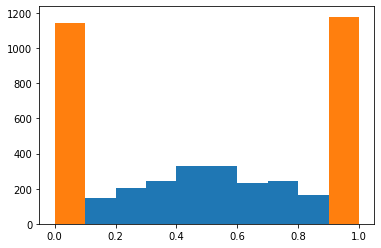

In [39]:
# generate normal distribution data set

import numpy as np
mean = 0.5
std = 0.3
min_size = 0
max_size = 1
dumb_model_prob = np.clip((np.random.normal(mean,std, len(X_test_1))),min_size,max_size)
dumb_model_yes = np.round(dumb_model_prob)
plt.hist(dumb_model_prob)
plt.hist(dumb_model_yes)

df_dumb_model = pd.DataFrame({'churn_yes':dumb_model_yes, 'churn_prob':dumb_model_prob})
df_dumb_model

In [40]:
# evaluation function
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, f1_score
from sklearn.metrics import precision_recall_curve, average_precision_score



def model_evaluation(y_test, y_pred, y_pred_prob=None):
    
# input:
# y_pred: dataframe, in [0,1]
# y_pred_prob: dataframe, between (0,1)
# y_test: dataframe, in [0,1]
# example: model_evaluation(y_test_1, df_dumb_model.churn_yes, df_dumb_model.churn_prob ):


    y_pred_tmp = y_pred
    y_pred_prob = y_pred_prob
    y_test_tmp = y_test
    
# classification report
    print('classification_report')
    print(classification_report(y_test_tmp,y_pred_tmp, zero_division=0))

# confusion matrix
    plt.figure(figsize=(9,6))
    cf_matrix = confusion_matrix(y_pred_tmp, y_test_tmp, labels=[1,0])
    # X_axis_labels = y_test_1.unique()
    # Y_axis_labels = y_test_1.unique()
    # ax = sns.heatmap(cf_matrix, xticklabels=X_axis_labels, yticklabels=Y_axis_labels, annot=True, fmt="d", cmap="YlGnBu",square=True)
    sns.heatmap(cf_matrix, annot=True,  fmt="d", yticklabels=[1,0], xticklabels=[1,0])
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    ax.hlines(np.arange(1,7), *ax.get_xlim())
    ax.vlines(np.arange(1,7), *ax.get_ylim())
    plt.show()

# plot ROC curve and precision-recall curve in one plot
    plt.figure(figsize=(7,6))
    # ROC plot
    if y_pred_prob is not None:
        fpr, tpr, threshold = roc_curve(y_test_tmp, y_pred_prob)
        roc_auc = auc(fpr, tpr)
    # plt.title('Receiver Operating Characteristic')
        plt.scatter(fpr, tpr, c='b', s=1, label = 'ROC_AUC = %0.2f' % roc_auc)
    else:
        fpr, tpr, threshold = roc_curve(y_test_tmp, y_pred_tmp)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, 'b', label = 'ROC_AUC = %0.2f' % roc_auc)
    # plt.show()


    # precision-recall curve
    if y_pred_prob is not None:
        precision, recall, thresholds = precision_recall_curve(y_test_tmp, y_pred_prob)
        pr_auc = auc(recall,precision)
#     average_precision = average_precision_score(y_test_tmp, y_pred_prob)
    
    # plt.scatter(precision, recall, 'g', label = 'AP = %0.2f' % average_precision)
        plt.scatter(precision, recall, c='g', s=1, label = 'PR_AUC = %0.2f' % pr_auc)
    else: 
        precision, recall, thresholds = precision_recall_curve(y_test_tmp, y_pred_tmp)
        pr_auc = auc(recall,precision)
        plt.plot(precision, recall, 'g', label = 'PR_AUC = %0.2f' % pr_auc)
    plt.plot([0, 1], [0, 1],'r--')
    
    plt.title('Receiver Operating Characteristic/precision-recall curve in one plot')
    plt.legend(loc = 'center right', bbox_to_anchor=(1.3, 0.5))
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('TPR/Recall')
    plt.xlabel('FPR, Precision')
    plt.show()

classification_report
              precision    recall  f1-score   support

           0       0.73      0.49      0.59      1711
           1       0.26      0.50      0.34       610

    accuracy                           0.49      2321
   macro avg       0.50      0.50      0.47      2321
weighted avg       0.61      0.49      0.52      2321



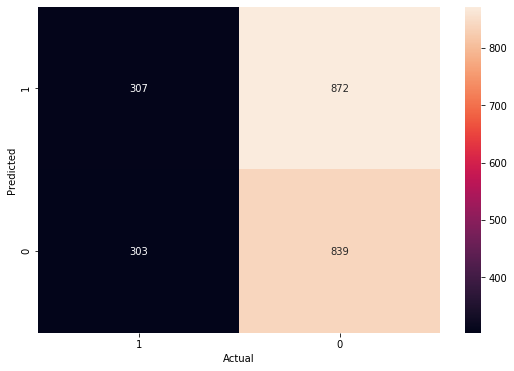

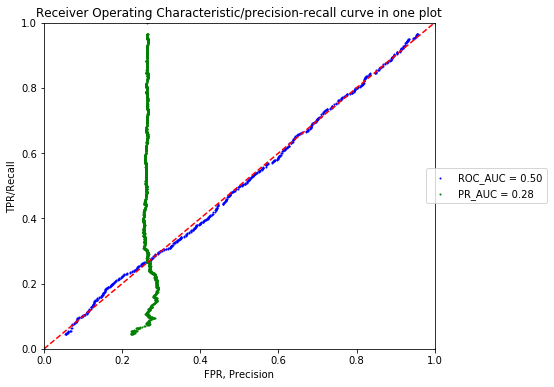

In [41]:
model_evaluation(y_test=y_test_1, y_pred=df_dumb_model.churn_yes, y_pred_prob=df_dumb_model.churn_prob )


##### intermediate summary
- We have generated a "dumb model" and evaluate its performance on the test set.
- There exist many metrics to evaluate model performance, i.e. precision, recall, accuracy, etc. 
- For this specific classification task with imblanced labels, we will choose "f1-score" as the most important metric when comparing model perforance, since f1-score takees into account both precision and recall performance.
- Among other metics, f1-score value can be found in classification report, the one we will focus on is "macro f1", which essentially means take un-weighted average across the f1-score in different classes.

### Logistic Regression (RG)

##### Training
- We can start with the default model, (meaning without tuning any of the hyper-parameters).

In [42]:
# train the default random forest model
from sklearn.linear_model import LogisticRegression

rg = LogisticRegression(   
#     C=1e-4,
#     penalty='l2',
#     solver='lbfgs',        
) 


rg.fit(X=X_train_1, y=y_train_1)
rg.get_params

# dtc.summary()


C:\Users\kefei\Anaconda3\envs\thinkful\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


<bound method BaseEstimator.get_params of LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)>

##### Prediction and evaluation on test set


In [43]:
y_pred_model = rg.predict(X_test_1)
y_prob_model = rg.predict_proba(X_test_1)[:,1]
# y_prob_model

print("f1-score on training set: {}".format(f1_score(y_true=y_train_1, y_pred=rg.predict(X_train_1))))
print("f1-score on test set: {}".format(f1_score(y_true=y_test_1, y_pred=rg.predict(X_test_1))))

f1-score on training set: 0.6142484795829714
f1-score on test set: 0.5885558583106267


classification_report
              precision    recall  f1-score   support

           0       0.84      0.90      0.87      1711
           1       0.66      0.53      0.59       610

    accuracy                           0.80      2321
   macro avg       0.75      0.72      0.73      2321
weighted avg       0.80      0.80      0.80      2321



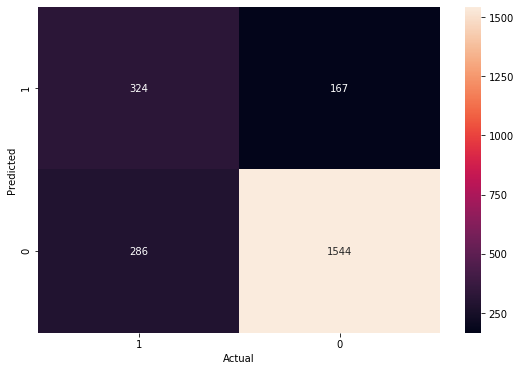

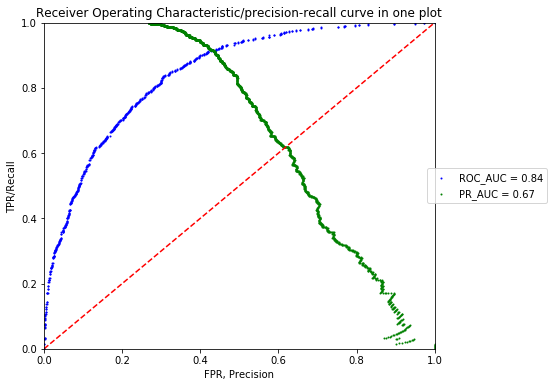

In [44]:
# evaluation metrics and visualization
model_evaluation(y_test=y_test_1, y_pred=pd.DataFrame({'pred_yes':y_pred_model}), y_pred_prob=y_prob_model)

### intermediate sumary
- Compare to the dumb model, the default logistic regression model performs much better in every metrics on both training set and test set.
- Also, when comparing the performanace on training set and test set, the f1-score didn't deteriate dramatically, so we should not be worry too much about overfitting in this case.
- But is it possible to improve the perforamnce by tuning the hyper-parameters? let's use GridSearchCV to find out.

## GridSearchCV verision
- Thy hyper-parameter of machine learning models can be tuned to improve performance. i.e. Inverse of regularization strength 'C' in logistic regress model
- Also, we can use grid search cross validation method to find out what would be the "best" hyper-parameters for a specific model.
- In this demo, we choose f1-score has metric when comparing model performance with different hyper-parameters. (since f1-score is a good balance to consider both precision and recall performance)
[use scoring](https://scikit-learn.org/stable/modules/model_evaluation.html)

In [45]:
# from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 

rg = LogisticRegression() 
   
param_grid = {
    'C': [1e-4, 1e-2, 1e-0,  1e2],
    'tol': [0.0001, 0.00001],
        
}
# Create a based model
lg = LogisticRegression(solver='lbfgs')
# Instantiate the grid search model
grid_search_lr = GridSearchCV(estimator = lg, param_grid = param_grid, 
                          cv = 5, 
                          scoring='f1',
                          n_jobs = -1, verbose = 0)


# Fit the random search model
_ = grid_search_lr.fit(X_train_1, y_train_1)
print(grid_search_lr.best_score_)
print(grid_search_lr.best_estimator_.get_params)

C:\Users\kefei\Anaconda3\envs\thinkful\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.6097077299035278
<bound method BaseEstimator.get_params of LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)>


In [46]:
# the scores of best estimator at each cross-validatioin n-fold
n_fold = 5
for fold in range(n_fold):
    print("test score in fold {}: {}".format(fold, 
                                          grid_search_lr.cv_results_['split'+str(fold)+'_test_score'][grid_search_lr.best_index_]))


test score in fold 0: 0.6164079822616408
test score in fold 1: 0.5738396624472573
test score in fold 2: 0.6200873362445415
test score in fold 3: 0.610752688172043
test score in fold 4: 0.6274509803921569


##### Prediction and evaluation on test set


In [47]:
y_pred_model = grid_search_lr.best_estimator_.predict(X_test_1)
y_prob_model = grid_search_lr.best_estimator_.predict_proba(X_test_1)[:,1]
# y_prob_model

print("f1-score on training set: {}".format(f1_score(y_true=y_train_1, y_pred=grid_search_lr.predict(X_train_1))))
print("f1-score on test set: {}".format(f1_score(y_true=y_test_1, y_pred=grid_search_lr.predict(X_test_1))))

f1-score on training set: 0.6142484795829714
f1-score on test set: 0.5885558583106267


classification_report
              precision    recall  f1-score   support

           0       0.84      0.90      0.87      1711
           1       0.66      0.53      0.59       610

    accuracy                           0.80      2321
   macro avg       0.75      0.72      0.73      2321
weighted avg       0.80      0.80      0.80      2321



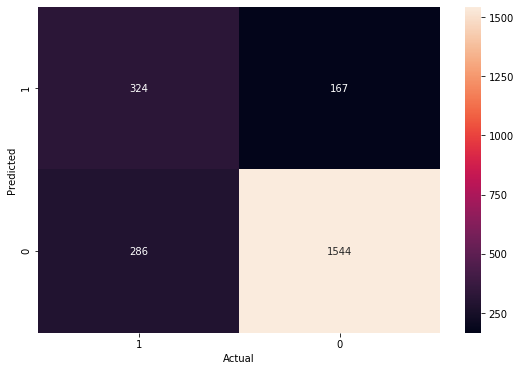

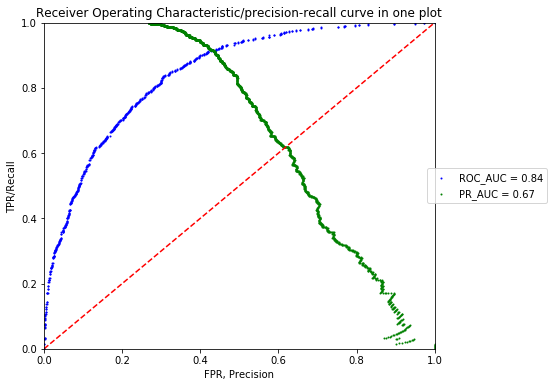

In [48]:
# evaluation metrics and visualization
model_evaluation(y_test=y_test_1, y_pred=pd.DataFrame({'pred_yes':y_pred_model}), y_pred_prob=y_prob_model)

### Trail with un-transformed data


##### check with the un-transformed data
- Recall that, in the former feature engineering process, we have performed quatile transformation to reduce outliers and achieve normality.
- So, let's compare the performance using data with transformation and without.

In [80]:
lg2 = LogisticRegression(max_iter=1000)

lg2.fit(X=X_train_2, y=y_train_1)
lg2.get_params


C:\Users\kefei\Anaconda3\envs\thinkful\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


<bound method BaseEstimator.get_params of LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)>

In [81]:
# quick evaluation

print("f1-score on training set: {}".format(f1_score(y_true=y_train_1, y_pred=lg2.predict(X_train_2))))
print("f1-score on test set: {}".format(f1_score(y_true=y_test_1, y_pred=lg2.predict(X_test_2))))
print('----------------')
print(classification_report(y_true=y_train_1, y_pred=lg2.predict(X_train_2), zero_division=0))
print(classification_report(y_true=y_test_1, y_pred=lg2.predict(X_test_2), zero_division=0))

f1-score on training set: 0.6063965884861408
f1-score on test set: 0.5863596102745792
----------------
              precision    recall  f1-score   support

           0       0.85      0.89      0.87      3452
           1       0.65      0.56      0.61      1259

    accuracy                           0.80      4711
   macro avg       0.75      0.73      0.74      4711
weighted avg       0.80      0.80      0.80      4711

              precision    recall  f1-score   support

           0       0.85      0.89      0.87      1711
           1       0.64      0.54      0.59       610

    accuracy                           0.80      2321
   macro avg       0.74      0.72      0.73      2321
weighted avg       0.79      0.80      0.79      2321



##### 
- It took more iteration for the model to converge, (i.e. we had increase max_iteration limit in this case)
- The performance deteriated comparing when using transformed data.
- Sometimes, the performance is so bad that the model might not even converge. (i.e. for SVM model)

##### intermediate summary
- It turned out the grid search model has the same perforamnce as the default one. It seems, in this case, the perforamnce is not likely to improve significantly by tuning the hyper-paramters.
- Let's move on and try some other models.
- Note that grid search CV is still very helpful so we will continue to use that, and hopefully to pay off in other situation.
- Note that it is possible to use certain more sophiscated hyper-parameter search approaches to optimize the searching process (i.e. less time, better performance). That being said, sometimes we need to search a wider range of hyper-parameter grid. But for illustration reason, we will demonstrate with simply grid with each hyper-parameter value close by the default sklearn settings.

## SVM

### training

In [49]:
from sklearn.svm import SVC

svmc = SVC()

svmc.fit(X=X_train_1, y=y_train_1)
svmc.get_params


C:\Users\kefei\Anaconda3\envs\thinkful\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


<bound method BaseEstimator.get_params of SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)>

In [50]:
# quick evaluation
# y_pred_model = grid_search_lr.best_estimator_.predict(X_test_1)
# y_prob_model = grid_search_lr.best_estimator_.predict_proba(X_test_1)[:,1]
# y_prob_model

print("f1-score on training set: {}".format(f1_score(y_true=y_train_1, y_pred=svmc.predict(X_train_1))))
print("f1-score on test set: {}".format(f1_score(y_true=y_test_1, y_pred=svmc.predict(X_test_1))))

f1-score on training set: 0.6156615661566156
f1-score on test set: 0.5607476635514019


In [51]:
# gridsearchcv
    
param_grid = {
#     'criterion': ['entropy', 'gini'],
    'C': [1e-2, 1e-0,  1e2],
#     'gamma': [1e7,1e5,1e3, 10, 1, 0.1],
    'gamma': ['scale', 'auto'],
    'kernel': ['rbf', 'linear'],
        
}
# Create a based model
svmc = SVC() 
# Instantiate the grid search model
grid_search_svm = GridSearchCV(estimator = svmc, param_grid = param_grid, 
                          cv = 5, 
                          scoring='f1',
                          n_jobs = -1, verbose = 0)


# Fit the random search model
_ = grid_search_svm.fit(X_train_1, y_train_1)
print(grid_search_svm.best_score_)
print(grid_search_svm.best_estimator_.get_params)

C:\Users\kefei\Anaconda3\envs\thinkful\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.6029099720711278
<bound method BaseEstimator.get_params of SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)>


In [52]:
y_pred_model = grid_search_svm.best_estimator_.predict(X_test_1)
# y_prob_model = grid_search_svm.best_estimator_.predict_proba(X_test_1)[:,1]
y_prob_model = y_pred_model
# y_prob_model

print("f1-score on training set: {}".format(f1_score(y_true=y_train_1, y_pred=grid_search_svm.predict(X_train_1))))
print("f1-score on test set: {}".format(f1_score(y_true=y_test_1, y_pred=grid_search_svm.predict(X_test_1))))

f1-score on training set: 0.6117440841367221
f1-score on test set: 0.5814167433302668


In [53]:
# the scores of best estimator at each cross-validatioin n-fold
grid_model_tmp = grid_search_svm
n_fold = 5
for fold in range(n_fold):
    print("test score in fold {}: {}".format(fold, 
                                          grid_model_tmp.cv_results_['split'+str(fold)+'_test_score'][grid_model_tmp.best_index_]))


test score in fold 0: 0.5924276169265034
test score in fold 1: 0.5646551724137931
test score in fold 2: 0.6217391304347826
test score in fold 3: 0.5995623632385121
test score in fold 4: 0.6361655773420479


classification_report
              precision    recall  f1-score   support

           0       0.84      0.91      0.87      1711
           1       0.66      0.52      0.58       610

    accuracy                           0.80      2321
   macro avg       0.75      0.71      0.73      2321
weighted avg       0.79      0.80      0.80      2321



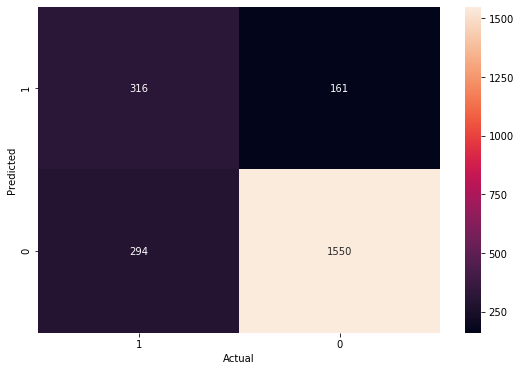

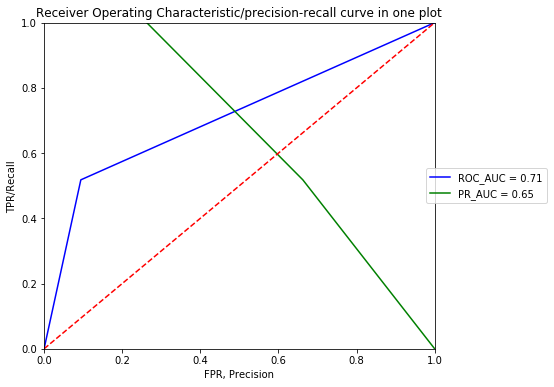

In [54]:
# evaluation metrics and visualization
model_evaluation(y_test=y_test_1, y_pred=pd.DataFrame({'pred_yes':y_pred_model}))

### intermedieate sumary
- As mentioned before, an essential reason we perform gridsearchCV is it can help avoid overfitting, and generate model that is more generalized to unseen data.
- From the SVM example we can see that, when comparing the default model vs. the best grid-searched-CV model. The default model has higer f1-score in training set, the score dropped in test set; while the grid-searched model is more generalized, and the difference of f1-score between training set and test set is smaller.
- However the SVM model doesn't outperform logistic regression model. (evaluated by f1-score). Also it takes longer for SVM to train the data compared to logistic regression.

### KNN
### training

In [67]:

from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()

knn.fit(X=X_train_1, y=y_train_1)
knn.get_params

C:\Users\kefei\Anaconda3\envs\thinkful\lib\site-packages\ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


<bound method BaseEstimator.get_params of KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')>

##### Prediction and evaluation on test set


In [69]:
y_pred_model = knn.predict(X_test_1)
y_prob_model = knn.predict_proba(X_test_1)[:,1]
# y_prob_model

print("f1-score on training set: {}".format(f1_score(y_true=y_train_1, y_pred=knn.predict(X_train_1))))
print("f1-score on test set: {}".format(f1_score(y_true=y_test_1, y_pred=knn.predict(X_test_1))))

f1-score on training set: 0.6818757921419518
f1-score on test set: 0.534468085106383


##### notice that the score dropped dramatically which indicates overfitting. So, in our gridsearchCV process, we can increase k value

In [104]:
# Gridsearch CV

param_grid = {
    'n_neighbors': [5, 50, 100, 150, 200, 250, 300],
    'weights': ['uniform', 'distance'],
    'leaf_size':[30, 60, 90],
        
}
# Create a based model
knn = KNeighborsClassifier()
# Instantiate the grid search model
grid_search_knn = GridSearchCV(estimator = knn, param_grid = param_grid, 
                          cv = 5, 
                          scoring='f1',
                          n_jobs = -1, verbose = 0)


# Fit the random search model
_ = grid_search_knn.fit(X_train_1, y_train_1)
print(grid_search_knn.best_score_)
print(grid_search_knn.best_estimator_.get_params)

0.5970009518213171
<bound method BaseEstimator.get_params of KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=250, p=2,
                     weights='uniform')>


C:\Users\kefei\Anaconda3\envs\thinkful\lib\site-packages\sklearn\model_selection\_search.py:739: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


In [105]:
y_pred_model = grid_search_knn.best_estimator_.predict(X_test_1)
# y_prob_model = grid_search_knn.best_estimator_.predict_proba(X_test_1)[:,1]
y_prob_model = y_pred_model
# y_prob_model

print("f1-score on training set: {}".format(f1_score(y_true=y_train_1, y_pred=grid_search_knn.predict(X_train_1))))
print("f1-score on test set: {}".format(f1_score(y_true=y_test_1, y_pred=grid_search_knn.predict(X_test_1))))

f1-score on training set: 0.5933877200515242
f1-score on test set: 0.5812115891132573


In [106]:
# the scores of best estimator at each cross-validatioin n-fold
grid_model_tmp = grid_search_knn
n_fold = 5
avg = []
for fold in range(n_fold):
    print("test score in fold {}: {}".format(fold, 
                                          grid_model_tmp.cv_results_['split'+str(fold)+'_test_score'][grid_model_tmp.best_index_]))
    avg.append(grid_model_tmp.cv_results_['split'+str(fold)+'_test_score'][grid_model_tmp.best_index_])
print("average: {}".format(np.mean(avg)))

test score in fold 0: 0.5797752808988763
test score in fold 1: 0.5714285714285714
test score in fold 2: 0.592436974789916
test score in fold 3: 0.6212765957446809
test score in fold 4: 0.6200873362445415
average: 0.5970009518213171


classification_report
              precision    recall  f1-score   support

           0       0.84      0.88      0.86      1711
           1       0.63      0.54      0.58       610

    accuracy                           0.79      2321
   macro avg       0.74      0.71      0.72      2321
weighted avg       0.79      0.79      0.79      2321



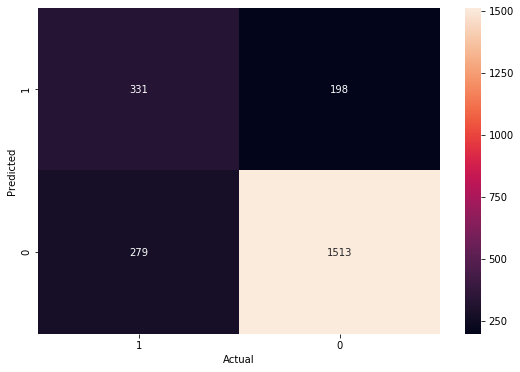

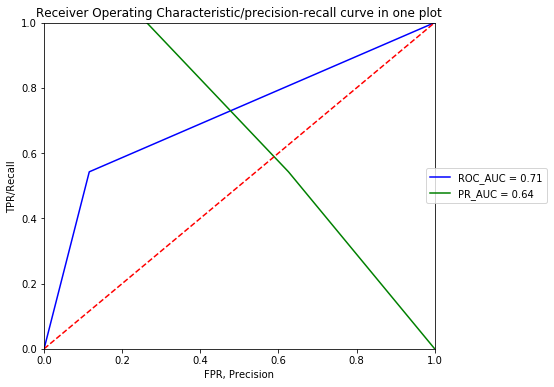

In [97]:
# evaluation metrics and visualization
model_evaluation(y_test=y_test_1, y_pred=pd.DataFrame({'pred_yes':y_pred_model}), y_pred_prob=None)

### intermediate sumary
- Again, cross-validation help to prevent overfitting
- By tuning K-neighbour parameter, we found a balance between decreasing bias and decreasing variance.
- For this model, the KNN model performs no better than logistic regression or SVM.

### Naive Bayes
##### training

In [108]:
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB()

nb.fit(X=X_train_1, y=y_train_1)
nb.get_params

C:\Users\kefei\Anaconda3\envs\thinkful\lib\site-packages\sklearn\naive_bayes.py:206: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


<bound method BaseEstimator.get_params of GaussianNB(priors=None, var_smoothing=1e-09)>

In [109]:
# quick evaluation

print("f1-score on training set: {}".format(f1_score(y_true=y_train_1, y_pred=nb.predict(X_train_1))))
print("f1-score on test set: {}".format(f1_score(y_true=y_test_1, y_pred=nb.predict(X_test_1))))

f1-score on training set: 0.6028248587570622
f1-score on test set: 0.586743515850144


## Decision Tree

## Random Forest

## Graident Boost